# Introduction

In this dataset, we have been provided with the volume of sales done for the past 1920 days with respect to each product across different stores and regions of the country.
Our objective is to come up with a model that takes the historical sales information and any additional feature, to forecast the next 21 days of sales for every product and every store in the training data.

# Import necessary modules

In [2]:
import pandas as pd
import numpy as np
import plotly.express as px

from sklearn import preprocessing
import gc
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMRegressor
import lightgbm as lgb
from sklearn.cluster import KMeans
from sklearn.model_selection import RandomizedSearchCV

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# Data Preparation 

In [2]:
train = pd.read_csv('train.csv')
prices = pd.read_csv('prices.csv')  
calendar =  pd.read_csv('calendar.csv')

train.head()

,id,item_id,subcat_id,category_id,store_id,region_id,d_1,d_2,d_3,d_4,...,d_1910,d_1911,d_1912,d_1913,d_1914,d_1915,d_1916,d_1917,d_1918,d_1919
0,Beauty_1_001_East_1,Beauty_1_001,Beauty_1,Beauty,East_1,East,0,0,0,0,...,3,0,1,1,0,0,0,2,0,3
1,Beauty_1_002_East_1,Beauty_1_002,Beauty_1,Beauty,East_1,East,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,Beauty_1_003_East_1,Beauty_1_003,Beauty_1,Beauty,East_1,East,0,0,0,0,...,0,1,1,1,0,0,1,1,0,2
3,Beauty_1_004_East_1,Beauty_1_004,Beauty_1,Beauty,East_1,East,0,0,0,0,...,1,3,7,2,0,0,1,2,4,1
4,Beauty_1_005_East_1,Beauty_1_005,Beauty_1,Beauty,East_1,East,0,0,0,0,...,2,2,2,4,1,0,2,3,1,0


In [3]:
train.info(), prices.info(), calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1925 entries, id to d_1919
dtypes: int64(1919), object(6)
memory usage: 447.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6841121 entries, 0 to 6841120
Data columns (total 4 columns):
 #   Column      Dtype  
---  ------      -----  
 0   store_id    object 
 1   item_id     object 
 2   wm_yr_wk    int64  
 3   sell_price  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 208.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      1969 non-null   object
 1   wm_yr_wk  1969 non-null   int64 
 2   weekday   1969 non-null   object
 3   wday      1969 non-null   int64 
 4   month     1969 non-null   int64 
 5   year      1969 non-null   int64 
 6   d         1969 non-null   object
dtypes: int64(4), object(3)
memory usage: 107.8+ KB


(None, None, None)

As we can see, the size of the train dataset is large and this is to be handled by downcasting the datatypes according to the range of the values

In [3]:
def downcast(df):
    cols = df.dtypes.index.tolist()
    types = df.dtypes.values.tolist()
    for i,t in enumerate(types):
        if 'int' in str(t):
            if df[cols[i]].min() > np.iinfo(np.int8).min and df[cols[i]].max() < np.iinfo(np.int8).max:
                df[cols[i]] = df[cols[i]].astype(np.int8)
            elif df[cols[i]].min() > np.iinfo(np.int16).min and df[cols[i]].max() < np.iinfo(np.int16).max:
                df[cols[i]] = df[cols[i]].astype(np.int16)
            elif df[cols[i]].min() > np.iinfo(np.int32).min and df[cols[i]].max() < np.iinfo(np.int32).max:
                df[cols[i]] = df[cols[i]].astype(np.int32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.int64)
        elif 'float' in str(t):
            if df[cols[i]].min() > np.finfo(np.float16).min and df[cols[i]].max() < np.finfo(np.float16).max:
                df[cols[i]] = df[cols[i]].astype(np.float16)
            elif df[cols[i]].min() > np.finfo(np.float32).min and df[cols[i]].max() < np.finfo(np.float32).max:
                df[cols[i]] = df[cols[i]].astype(np.float32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.float64)
        elif t == np.object:
                df[cols[i]] = df[cols[i]].astype('category')
    return df 

In [5]:
train = downcast(train)
prices = downcast(prices)
calendar = downcast(calendar)

## Train 

In [6]:
train.head()

,id,item_id,subcat_id,category_id,store_id,region_id,d_1,d_2,d_3,d_4,...,d_1910,d_1911,d_1912,d_1913,d_1914,d_1915,d_1916,d_1917,d_1918,d_1919
0,Beauty_1_001_East_1,Beauty_1_001,Beauty_1,Beauty,East_1,East,0,0,0,0,...,3,0,1,1,0,0,0,2,0,3
1,Beauty_1_002_East_1,Beauty_1_002,Beauty_1,Beauty,East_1,East,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,Beauty_1_003_East_1,Beauty_1_003,Beauty_1,Beauty,East_1,East,0,0,0,0,...,0,1,1,1,0,0,1,1,0,2
3,Beauty_1_004_East_1,Beauty_1_004,Beauty_1,Beauty,East_1,East,0,0,0,0,...,1,3,7,2,0,0,1,2,4,1
4,Beauty_1_005_East_1,Beauty_1_005,Beauty_1,Beauty,East_1,East,0,0,0,0,...,2,2,2,4,1,0,2,3,1,0


## Calendar

In [7]:
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d
0,2011-01-29,11101,Saturday,1,1,2011,d_1
1,2011-01-30,11101,Sunday,2,1,2011,d_2
2,2011-01-31,11101,Monday,3,1,2011,d_3
3,2011-02-01,11101,Tuesday,4,2,2011,d_4
4,2011-02-02,11101,Wednesday,5,2,2011,d_5


## Prices

In [8]:
prices.head()

,store_id,item_id,wm_yr_wk,sell_price
0,East_1,Beauty_1_001,11325,9.578125
1,East_1,Beauty_1_001,11326,9.578125
2,East_1,Beauty_1_001,11327,8.257812
3,East_1,Beauty_1_001,11328,8.257812
4,East_1,Beauty_1_001,11329,8.257812


In [9]:
train.info(), prices.info(), calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1925 entries, id to d_1919
dtypes: category(6), int16(1309), int8(610)
memory usage: 95.4 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6841121 entries, 0 to 6841120
Data columns (total 4 columns):
 #   Column      Dtype   
---  ------      -----   
 0   store_id    category
 1   item_id     category
 2   wm_yr_wk    int16   
 3   sell_price  float16 
dtypes: category(2), float16(1), int16(1)
memory usage: 45.8 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   date      1969 non-null   category
 1   wm_yr_wk  1969 non-null   int16   
 2   weekday   1969 non-null   category
 3   wday      1969 non-null   int8    
 4   month     1969 non-null   int8    
 5   year      1969 non-null   int16   
 6   d         1969 non-null   category
dtypes: category(3), int

(None, None, None)

Now that we have handled the memory usage of our data, our RAM should be able to manage this load with ease during computations.

#### Converging the dataframes into a master dataframe inorder to perform Exploratory Data Analysis

In [10]:
df = pd.melt(train, id_vars=['id', 'item_id', 'subcat_id', 'category_id', 'store_id', 'region_id'], var_name='d', value_name='sold').dropna()

In [11]:
df = pd.merge(df, calendar, on='d', how='left')
df = pd.merge(df, prices, on=['store_id','item_id','wm_yr_wk'], how='left') 
df['revenue'] = df['sold']*df['sell_price'].astype(np.float32)

df = downcast(df) 

# Exploratory Data Analysis

In [12]:
print("We have {} unique items under {} categories across {} regions and {} stores".format(df['item_id'].nunique(),df['category_id'].nunique(),df['region_id'].nunique(),df['store_id'].nunique()))
print("The categories are {}".format(list(df['category_id'].unique())))
print("The regions are {}".format(list(df['region_id'].unique())))
print("The stores are {}".format(list(df['store_id'].unique())))
print('This dataset comprises {} Beauty Products, {} Cleaning Products, {} Food Products'.format(df[df['category_id']=='Beauty']['item_id'].nunique(),df[df['category_id']=='Cleaning']['item_id'].nunique(),df[df['category_id']=='Food']['item_id'].nunique()))

We have 3049 unique items under 3 categories across 3 regions and 10 stores
The categories are ['Beauty', 'Cleaning', 'Food']
The regions are ['East', 'Central', 'West']
The stores are ['East_1', 'East_2', 'East_3', 'East_4', 'Central_1', 'Central_2', 'Central_3', 'West_1', 'West_2', 'West_3']
This dataset comprises 565 Beauty Products, 1047 Cleaning Products, 1437 Food Products


In [13]:
temp = df.groupby(['category_id','date'])['sold'].sum().reset_index().sort_values('date')
fig = px.scatter(temp, x=temp['date'],template="seaborn",
                 y=temp['sold'],color_discrete_sequence=px.colors.qualitative.Plotly,
                 color='category_id', height =600, width = 1000)

layout = dict(
    title_text = "<b> Sales Trend of Different Categories </b>",
    font=dict(size=12),
    title_x = 0.5)
fig.update_traces(mode = 'lines')
fig.update_layout(layout, legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.01
))
fig.show()

We can notice that Food items' sales are high at all time and is certainly more than the sum of the sales made by beauty and cleaning products together.

In [14]:
sample = df.sample(5)
sample_IDs = list(sample['id'].values)

fig = make_subplots(rows=4, cols=1, subplot_titles=[ele for ele in sample_IDs])

for i in range(1,5):
    x = df.loc[df['id']==sample_IDs[i]]['d']
    y = df.loc[df['id']==sample_IDs[i]]['sold']
    fig.add_trace(
    go.Scatter(x=x, y=y, name = sample_IDs[i]),
    row=i, col=1
    )

layout = dict(
    title_text = "<b> Sales Distribution of Random Products </b>",
    font=dict(size=12),
    title_x = 0.5)

fig.update_layout(layout,template = 'seaborn',showlegend = False,
                    height=1500, width=1000)

fig.show()

We can observe that the sales trend for each product is erratic and filled with noise. 

In the case of Cleaning_1_431_West_1, the plot shows a lot of randomness with a lot of days where the product was never sold at all. This could imply the product going out of stock but since we have no inventory data available, this hypothesis couldn't be rationalized.

Overall, we see a lot of noise along with a lot of sparse values (Nil Sales) with respect to the sales trend of any product which tells us that using a metric like MAPE during our modelling would not yield the best results.

In [15]:
temp = df.groupby(['category_id','month'])['sold'].mean().reset_index()
fig = make_subplots(rows=3, cols=1, subplot_titles=list(df['category_id'].unique()))

for ix,ele in enumerate(list(df['category_id'].unique()),1):
    x = temp.loc[temp['category_id']==ele]['month']
    y = temp.loc[temp['category_id']==ele]['sold']
    fig.add_trace(
    go.Scatter(x=x, y=y),
    row=ix, col=1
    )

layout = dict(
    title_text = "<b> Monthly Sales Distribution Per Category </b>",
    font=dict(size=12),
    title_x = 0.5)

fig.update_layout(layout,template = 'seaborn',showlegend = False,
                    height=600, width=700)

fig.show()


This plot shows that the avergage sales made by all three categories drop during the month of May. However, in the case of beauty products, major dip is found only during the month of october. 

Key takeaways from this plot is that it would be imperative for the procurement manager of the store to decrease the volume order of food for the month of may.

In [16]:
temp = df.groupby(['category_id','wday'])['sold'].sum().reset_index()
fig = make_subplots(rows=3, cols=1, subplot_titles=list(df['category_id'].unique()))

for ix,ele in enumerate(list(df['category_id'].unique()),1):
    x = temp.loc[temp['category_id']==ele]['wday']
    y = temp.loc[temp['category_id']==ele]['sold']
    fig.add_trace(
    go.Scatter(x=x, y=y),
    row=ix, col=1
    )

layout = dict(
    title_text = "<b> Weekly Sales Distribution Per Category </b>",
    font=dict(size=12),
    title_x = 0.5)

fig.update_layout(layout,template = 'seaborn',showlegend = False,
                    height=600, width=700)

fig.show()


<b> Note: </b> <br>
1 corresponds to Saturday, 2 corresponds to Sunday and this goes on for 7 corresponding to Friday. <br>


This plot tells us that most people prefer to shop the given categories during the weekends rather than mid-week.

In [17]:
temp = df.groupby(['region_id','store_id','category_id'])['sold'].mean().reset_index()
fig = px.sunburst(temp, path=['region_id','store_id','category_id'], values='sold',
                  color='sold', 
                  color_continuous_scale='RdBu')

layout = dict(
    title_text = "<b> Average sales on all categories across all regions and stores </b>",
    font=dict(size=12),
    title_x = 0.5)

fig.update_layout(layout,template = 'seaborn',showlegend = False,
                    height=600, width=700)
fig.show()

In [18]:
def split_category(dt):
    return [dt[dt['category_id'] == y] for y in dt['category_id'].unique()]

temp = df.groupby(['year','month','weekday','category_id'])['sold'].mean().reset_index()
temp['sold'].fillna(0,inplace=True)


res = split_category(temp)

cat_val = pd.DataFrame(res[0]).groupby(['month','weekday'])['sold'].mean().reset_index().pivot("weekday", "month", "sold")
fig = px.imshow(cat_val,color_continuous_scale='RdYlBu_r')

layout = dict(
    title_text = "<b> Beauty </b>",
    font=dict(size=12),
    title_x = 0.5)
fig.update_layout(layout,template = 'plotly_dark',height=400, width=1000)
fig.show()


cat_val = pd.DataFrame(res[1]).groupby(['month','weekday'])['sold'].mean().reset_index().pivot("weekday", "month", "sold")
fig = px.imshow(cat_val,color_continuous_scale='RdYlBu_r')
layout = dict(
    title_text = "<b> Cleaning </b>",
    font=dict(size=12),
    title_x = 0.5)
fig.update_layout(layout,template = 'plotly_dark',height=400, width=1000)
fig.show()

cat_val = pd.DataFrame(res[2]).groupby(['month','weekday'])['sold'].mean().reset_index().pivot("weekday", "month", "sold")
fig = px.imshow(cat_val,color_continuous_scale='RdYlBu_r')
layout = dict(
    title_text = "<b> Food </b>",
    font=dict(size=12),
    title_x = 0.5)
fig.update_layout(layout,template = 'plotly_dark',height=400, width=1000)
fig.show()

The 3 heatmaps shows the weekly trend in the quatity of beauty, cleaning, and food products in a year. 

>Beauty Products

From the given heatmap we can draw the following conclusions:
- Throughout the year, the quantity of beauty products sold between Monday and Thursday are low.
- The quantity of beauty products sold is highest during the wekends of the first 4 months of a year. 
- The quatity of beauty products sold on weekends decreases after May, however, the sales is relatively high on Saturdays as weekdays.

> Cleaning products

From the given heatmap we can draw the following conclusions:
- Throughout the year, the quantity of cleaning products sold between Tuesday and Thursday are low. 
- The quantity of cleaning products sold is highest during the wekends of the first 4 months of a year.
- The quatity of cleaning products sold decreases after May, however, the sales is relatively high during the weekend as compared to weekdays.


> Food products: 

From the given heatmap we can draw the following conclusions:
- Throughout the year, the quantity of food products sold between Tuesday and Thursday are low.
- The quantity of food products sold is highest during the wekends and relatively high on Monday and Friday as compared to the other weekdays in the first 4 months of a year. 
- The quatity of food products sold on weekends decreases after May.The quatity sold is spread out across the week, however, the sales remains relatively high during the weekend as compared to weekdays.

> Overall

From the three heatmaps, we can see that the top sales is recorded on weekends across all three product categories. Moreover, we see that the highest number of sales takes places during the weekends of months- January, February, March, and April. In the months between May and December, we see that the sales of products is spread out throughout the week with relatively higher sales being recorded on the weekends. 

> The reason that could possibly attribute to this trend is that customers tend to stock more supplies during peak winter and beginning of summer.




# Model Building

## Feature Engineering for our Models

### Label Encode Categorical Features

In [22]:
le = LabelEncoder()
def encode_categorical(df, cols):
    for col in cols:
        df[col] = pd.Series(le.fit_transform(df[col]), index=df.index)
    return df

In [23]:
df = encode_categorical(df,['item_id', 'subcat_id', 'category_id', 'store_id', 'region_id',
       'd']).pipe(downcast)

### Lags (Shifts) as feature

This will allow us to capture auto correlation between values that are certain time period apart.

In [24]:
lags = [1,2,3,6,12,24,364]
for lag in lags:
    df['sold_lag_'+str(lag)] = df.groupby(['id', 'item_id', 'subcat_id', 'category_id', 'store_id', 'region_id'],as_index=False)['sold'].shift(lag).astype(np.float16)

### Mean Encoding

We are again converting categorical features into numerical. This creates a feature that is more representative of the target variable by considering the avergage with respect to different groups.

In [25]:
df['item_sold_avg'] = df.groupby('item_id')['sold'].transform('mean').astype(np.float16)
df['region_sold_avg'] = df.groupby('region_id')['sold'].transform('mean').astype(np.float16)
df['store_sold_avg'] = df.groupby('store_id')['sold'].transform('mean').astype(np.float16)
df['cat_sold_avg'] = df.groupby('category_id')['sold'].transform('mean').astype(np.float16)
df['subcat_sold_avg'] = df.groupby('subcat_id')['sold'].transform('mean').astype(np.float16)
df['store_item_sold_avg'] = df.groupby(['store_id','item_id'])['sold'].transform('mean').astype(np.float16)
df['cat_item_sold_avg'] = df.groupby(['category_id','item_id'])['sold'].transform('mean').astype(np.float16)
df['region_store_sold_avg'] = df.groupby(['region_id','store_id'])['sold'].transform('mean').astype(np.float16)
df['region_store_cat_sold_avg'] = df.groupby(['region_id','store_id','category_id'])['sold'].transform('mean').astype(np.float16)
df['store_cat_subcat_sold_avg'] = df.groupby(['store_id','category_id','subcat_id'])['sold'].transform('mean').astype(np.float16)

### Rolling Mean or Moving Avergage Feature
This calculation creates an updated average value for each row based on the window size we specify.

In [26]:
df['rolling_sold_mean'] = df.groupby(['id', 'item_id', 'subcat_id', 'category_id', 'store_id', 'region_id'])['sold'].transform(lambda x: x.rolling(window=7).mean()).astype(np.float16)

df['rolling_revenue_mean'] = df.groupby(['id', 'item_id', 'subcat_id', 'category_id', 'store_id', 'region_id'])['revenue'].transform(lambda x: x.rolling(window=7).mean()).astype(np.float16)


### Expanding Mean

While the rolling window uses the same amount of observations each time, and the expanding window uses more and more observations each time

In [27]:
df['expanding_sold_mean'] = df.groupby(['id', 'item_id', 'subcat_id', 'category_id', 'store_id', 'region_id'])['sold'].transform(lambda x: x.expanding(2).mean()).astype(np.float16)

df['expanding_revenue_mean'] = df.groupby(['id', 'item_id', 'subcat_id', 'category_id', 'store_id', 'region_id'])['revenue'].transform(lambda x: x.expanding(2).mean()).astype(np.float16)

### Trends 

The selling trend feature will be positive if the daily items sold are greater than the entire duration average else negative.

In [28]:
df['daily_avg_sold'] = df.groupby(['id', 'item_id', 'subcat_id', 'category_id', 'store_id', 'region_id','d'])['sold'].transform('mean').astype(np.float16)
df['avg_sold'] = df.groupby(['id', 'item_id', 'subcat_id', 'category_id', 'store_id', 'region_id'])['sold'].transform('mean').astype(np.float16)
df['selling_trend'] = (df['daily_avg_sold'] - df['avg_sold']).astype(np.float16)
df.drop(['daily_avg_sold','avg_sold'],axis=1,inplace=True)

df['daily_avg_revenue'] = df.groupby(['id', 'item_id', 'subcat_id', 'category_id', 'store_id', 'region_id','d'])['revenue'].transform('mean').astype(np.float16)
df['avg_revenue'] = df.groupby(['id', 'item_id', 'subcat_id', 'category_id', 'store_id', 'region_id'])['revenue'].transform('mean').astype(np.float16)
df['revenue_trend'] = (df['daily_avg_revenue'] - df['avg_revenue']).astype(np.float16)
df.drop(['daily_avg_revenue','avg_revenue'],axis=1,inplace=True)

In [ ]:
# To elimate null values created from creating the lag features
df = df[df['d']>=max(lags)]
df = downcast(df)

In [30]:
df.to_pickle('data.pkl')
del df
gc.collect();

## Training Using LGBM - Tweedie

LGBM is known to handle large datasets with low memory usage without compromising on accuracy. Tweedie objective is commonly used for sales data that is almosy always skewed due to various reasons.

In [4]:
df = pd.read_pickle('data.pkl')
df = downcast(df)

This should've been part of feature engineering but since model building on the whole is an iterative process, I'm adding this piece of code here.

Note: Including features from Kmeans clustering did not improve the efficiency of the much. 
In the interest of time, I'm skipping over this part. 
In the future, we could check by tuning the hyperparameters for Kmeans and calculating the silhoutte score to determine the appropriate number of clusters needed and use that to transform our data.

```
features = ['item_id', 'subcat_id', 'category_id', 'store_id', 'region_id',
       'd', 'wm_yr_wk', 'wday', 'month', 'year']
kmeans_model = KMeans(n_clusters=4, init="k-means++", n_init=1, verbose=0, max_iter=1000)
df_scaled = preprocessing.StandardScaler().fit_transform(df[features])
kmeans = kmeans_model.fit(df_scaled)  #fitting to scaled model as Kmeans is sensitive to outliers 
kmeans_distances = kmeans.transform(df_scaled)  

kmeans_distances = kmeans_distances.astype(np.float16)  

for i in range(kmeans_distances.shape[1]):
    df['K'+str(i+1)]= kmeans_distances[:,i].astype(np.float16)
```

In [5]:
train = df[df['d']<1877]
val = df[(df['d']>=1877) & (df['d']<1898)]
test = df[df['d']>=1898]

In [6]:
df.columns

Index(['id', 'item_id', 'subcat_id', 'category_id', 'store_id', 'region_id',
       'd', 'sold', 'date', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year',
       'sell_price', 'revenue', 'sold_lag_1', 'sold_lag_2', 'sold_lag_3',
       'sold_lag_6', 'sold_lag_12', 'sold_lag_24', 'sold_lag_364',
       'item_sold_avg', 'region_sold_avg', 'store_sold_avg', 'cat_sold_avg',
       'subcat_sold_avg', 'store_item_sold_avg', 'cat_item_sold_avg',
       'region_store_sold_avg', 'region_store_cat_sold_avg',
       'store_cat_subcat_sold_avg', 'rolling_sold_mean',
       'rolling_revenue_mean', 'expanding_sold_mean', 'expanding_revenue_mean',
       'selling_trend', 'revenue_trend'],
      dtype='object')

In [7]:
features =['item_id', 'subcat_id', 'category_id', 'store_id', 'region_id',
        'wm_yr_wk', 'weekday', 'wday', 'month', 'year',
       'sell_price', 'revenue', 'sold_lag_1', 'sold_lag_2', 'sold_lag_3',
       'sold_lag_6', 'sold_lag_12', 'sold_lag_24', 'sold_lag_364',
       'item_sold_avg', 'region_sold_avg', 'store_sold_avg', 'cat_sold_avg',
       'subcat_sold_avg', 'store_item_sold_avg', 'cat_item_sold_avg',
       'region_store_sold_avg', 'region_store_cat_sold_avg',
       'store_cat_subcat_sold_avg', 'rolling_sold_mean',
       'rolling_revenue_mean', 'expanding_sold_mean', 'expanding_revenue_mean',
       'selling_trend', 'revenue_trend']  

train_set = lgb.Dataset(train[features], train['sold'])
val_set = lgb.Dataset(val[features], val['sold'])

In [8]:
params = {'random_seed' :36,   #random set of parameters
        'learning_rate':0.1,
        'subsample':0.8,
        'colsample_bytree':0.8,
        'max_depth':8,
        'num_leaves':50,
        'min_child_weight':300,
        'objective': 'tweedie'}


params['metric'] = 'rmse'
num_round = 2500


model = lgb.train(params, train_set,num_round,callbacks=[lgb.early_stopping(stopping_rounds=100),lgb.log_evaluation(period = 30)],
                   valid_sets = val_set)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 1.542904 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4128
[LightGBM] [Info] Number of data points in the train set: 46131370, number of used features: 35


C:\Users\Derin Ben Roberts\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\Derin Ben Roberts\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Info] Start training from score 0.114986
Training until validation scores don't improve for 100 rounds
[30]	valid_0's rmse: 2.04394
[60]	valid_0's rmse: 1.03747
[90]	valid_0's rmse: 0.958318
[120]	valid_0's rmse: 0.929927
[150]	valid_0's rmse: 0.888432
[180]	valid_0's rmse: 0.880816
[210]	valid_0's rmse: 0.869161
[240]	valid_0's rmse: 0.86469
[270]	valid_0's rmse: 0.854057
[300]	valid_0's rmse: 0.838416
[330]	valid_0's rmse: 0.84018
[360]	valid_0's rmse: 0.839665
[390]	valid_0's rmse: 0.829688
[420]	valid_0's rmse: 0.833846
[450]	valid_0's rmse: 0.833117
[480]	valid_0's rmse: 0.830449
Early stopping, best iteration is:
[385]	valid_0's rmse: 0.824001


In [9]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())
    
y_pred = model.predict(val[features])
rmse(y_pred,val['sold'])

0.8240006416390522

In [10]:
predictions = model.predict(test[features])

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

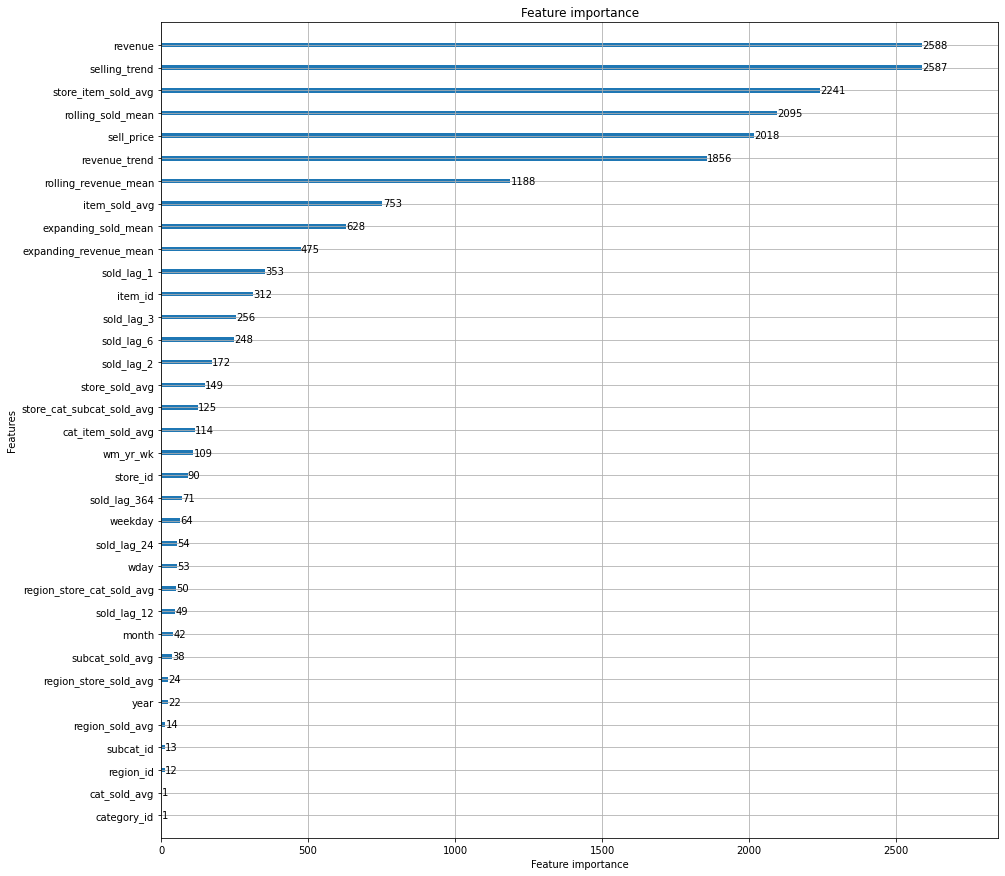

In [11]:
lgb.plot_importance(model,figsize= (15,15))

We can observe that most of our engineered features influenced the learning of the model. We could go ahead and create more featuers such as rolling minimum/maximum of sold/revenue column, expanding window maximum/minimum of sold/revenue column to add more features that better represent the target.

### HyperParameter Tuning

It would be efficient to get hold of the hyperparameters that we want to choose in the first place.

- num_leaves: maximum number of leaves in one tree, main parameter to tune for a tree model
- min_child_samples: Minimum number of data in one leaf
- max_depth: maximum depth of the tree

For this point in time, due to time constraints, I'm resorting to Randomized Search as it gives me more time to try out more rounds of tuning. 

During the initial stages of tuning, I am choosing values that fall on both sides of random value that we chose for training our model on top. This should provide us with the direction we would take and further narrow our search space.

In [ ]:
parameters = {'num_leaves':[40,50,60],
             'min_child_samples':[200,500,800],
             'max_depth':[4,8,12]}

lgb = LGBMRegressor()

clf=RandomizedSearchCV(lgb,parameters,scoring='neg_root_mean_squared_error',n_jobs=-1,verbose=2)
clf.fit(X=train[features], y=train['sold'])
print(clf.best_params_)
y_pred=clf.predict(val[features])
rmse(y_pred,val['sold'])

# Predictions

In [12]:
test = df[df['d']>=1898][['id','d','sold']]

test['sold'] = predictions
predictions = test[['id','d','sold']]
predictions = pd.pivot(predictions, index = 'id', columns = 'd', values = 'sold').reset_index()
predictions.columns = ['id'] + ['D' + str(i + 1) for i in range(21)]
cols = predictions.columns

for col in cols:
    if col == 'id':
        continue
    else:
        predictions[col] = np.round_(predictions[col])
predictions.to_csv('submission.csv',index = False)